In [1]:
# Importing required libraries
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as nn_utils
import math
import random
import copy
import time
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output


warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
IDE = 'Colab' # 'Colab' or 'VSCode'
def seed_all(seed=None):
    if seed is None:
        seed = 87 + 122

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_all()

## Parameters

In [3]:
class Args:
    def __init__(self):
        self.h1_dim = 128
        self.h2_dim = 64
        self.gamma = 0.99 # Discount factor (constant)
        self.lr = 1e-3
        self.batch_size = 32 # Batch size for experience replay
        self.buffer_size = int(1e4) # Experience replay buffer size
        self.target_update_freq = 20 # Frequency of updating target network
        self.max_episodes = 1000
        self.max_steps = 500
        self.runs = 5
        self.epsilon0 = 1.0
        self.min_epsilon = 0.001
        self.epsilon_decay = 0.99
        self.print_freq = 200

args = Args()

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_all()

## Dueling DQN

In [5]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

In [6]:
# Dueling DQN
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim, update_type=1, args=args):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)

        self.value = nn.Linear(args.h2_dim, 1)
        self.advantage = nn.Linear(args.h2_dim, action_dim)
        self.update_type = update_type
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value(x)
        advantage = self.advantage(x)

        if self.update_type == 1:
            q = value + (advantage - advantage.mean(dim=-1, keepdim=True))
        elif self.update_type == 2:
            q = value + (advantage - advantage.max(dim=-1, keepdim=True)[0])
        else:
            raise NotImplementedError("Update type not implemented")

        return q


In [7]:
# Dueling DQN Agent
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, update_type=1, args=args):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.update_type = update_type
        self.q_net = DuelingDQN(state_dim, action_dim, update_type, args).to(device)
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=args.lr)
        self.loss_fn = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(args.buffer_size)
        self.steps = 0

    def act(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_net(state)
        return q_values.argmax().item()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < args.batch_size:
            return 0

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(args.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_net(states)
        next_q_values = self.target_net(next_states).detach()

        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(dim=-1)[0]
        target = rewards + args.gamma * next_q_value * (1 - dones)

        loss = self.loss_fn(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % args.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        return loss.item()

    def save(self, path):
        torch.save(self.q_net.state_dict(), path)

    def load(self, path):
        self.q_net.load_state_dict(torch.load(path))
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()



## Monte-Carlo REINFORCE

In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, args=args):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)
        self.fc3 = nn.Linear(args.h2_dim, action_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)


In [9]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, args=args):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)
        self.fc3 = nn.Linear(args.h2_dim, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
class MonteCarloREINFORCEAgent:
    def __init__(self, state_dim, action_dim, baseline=False, args=args):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = PolicyNetwork(state_dim, action_dim, args).to(device)
        self.value_net = ValueNetwork(state_dim, args).to(device)
        self.optimizer = optim.Adam(list(self.policy_net.parameters()) + list(self.value_net.parameters()), lr=args.lr)
        self.baseline = baseline
        self.loss_fn = nn.MSELoss()
        self.steps = 0

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.policy_net(state)
        return torch.distributions.Categorical(probs).sample().item()

    def update(self, trajectory):
        states, actions, rewards = zip(*trajectory)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)

        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + args.gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns).to(device)

        probs = self.policy_net(states)
        log_probs = torch.log(probs.gather(1, actions.unsqueeze(1)).squeeze(1))

        if self.baseline:
            values = self.value_net(states).squeeze(1)
            advantages = returns - values
            loss = -torch.sum(log_probs * advantages)
            value_loss = self.loss_fn(values, returns)
            loss += value_loss
        else:
            loss = -torch.sum(log_probs * returns)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        return loss.item()

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load(self, path):
        self.policy_net.load_state_dict(torch.load(path))


## Trainer

In [11]:
# Training for Dueling DQN and REINFORCE
class Trainer:
    def __init__(self, env_name, agent_type, update_type=None, baseline=False, args=args):
        self.env_name = env_name
        self.agent_type = agent_type
        self.update_type = update_type
        self.baseline = baseline
        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

    def get_agent(self):
        if self.agent_type == "dueling_dqn":
            return DuelingDQNAgent(self.state_dim, self.action_dim, self.update_type, args)
        elif self.agent_type == "reinforce":
            return MonteCarloREINFORCEAgent(self.state_dim, self.action_dim, self.baseline, args)
        else:
            raise NotImplementedError("Agent not implemented")

    def train(self):
        # run for 5 random seeds and average the results
        # reinstaniate the agent for each run
        rewards = np.zeros((args.runs, args.max_episodes))
        losses = np.zeros((args.runs, args.max_episodes))
        for run in tqdm(range(args.runs)):
            seed_all(seed=run)
            self.agent = self.get_agent()
            rewards[run], losses[run] = self.train_single_run()
            clear_output(wait=True)
        self.rewards_mean = rewards.mean(axis=0)
        self.rewards_std = rewards.std(axis=0)
        self.losses_mean = losses.mean(axis=0)
        self.losses_std = losses.std(axis=0)
        self.save() # Save the results
        return self.rewards_mean, self.rewards_std, self.losses_mean, self.losses_std

    def train_single_run(self):
        if self.agent_type == "dueling_dqn":
            return self.train_DuelingDQN()
        elif self.agent_type == "reinforce":
            return self.train_MC_REINFORCE()
        else:
            raise NotImplementedError("Agent not implemented")

    def train_DuelingDQN(self):
        rewards = []
        losses = []
        for episode in range(args.max_episodes):
            if IDE == 'Colab':
                state = self.env.reset()
            else:
                state, _ = self.env.reset()
            episode_reward = 0
            for step in range(args.max_steps):
                epsilon = max(args.min_epsilon, args.epsilon0 * args.epsilon_decay**self.agent.steps)
                action = self.agent.act(state, epsilon)
                if IDE == 'Colab':
                    next_state, reward, done, _ = self.env.step(action)
                else:
                    next_state, reward, done, _, _ = self.env.step(action)
                loss = self.agent.update(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                if done:
                    break
            rewards.append(episode_reward)
            losses.append(loss)
            if episode % args.print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        return rewards, losses

    def train_MC_REINFORCE(self):
        rewards = []
        losses = []
        for episode in range(args.max_episodes):
            if IDE == 'Colab':
                state = self.env.reset()
            else:
                state, _ = self.env.reset()
            episode_reward = 0
            trajectory = []
            for step in range(args.max_steps):
                action = self.agent.act(state)
                if IDE == 'Colab':
                    next_state, reward, done, _ = self.env.step(action)
                else:
                    next_state, reward, done, _, _ = self.env.step(action)
                trajectory.append((state, action, reward))
                state = next_state
                episode_reward += reward
                if done:
                    break
            rewards.append(episode_reward)
            loss = self.agent.update(trajectory)
            losses.append(loss)
            if episode % args.print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        return rewards, losses

    def save(self):
        if self.agent_type == "dueling_dqn":
            os.makedirs("results", exist_ok=True)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_rewards_mean.npy", self.rewards_mean)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_rewards_std.npy", self.rewards_std)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_losses_mean.npy", self.losses_mean)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_losses_std.npy", self.losses_std)
        elif self.agent_type == "reinforce":
            os.makedirs("results", exist_ok=True)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_rewards_mean.npy", self.rewards_mean)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_rewards_std.npy", self.rewards_std)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_losses_mean.npy", self.losses_mean)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_losses_std.npy", self.losses_std)
        else:
            raise NotImplementedError("Agent not implemented")

    # def save(self, path):
    #     self.agent.save(path)

    # def load(self, path):
    #     self.agent.load(path)

In [12]:
def results_loader(env_name, agent_type, update_type=None, baseline=False):
    if agent_type == "dueling_dqn":
        rewards_mean = np.load(f"results/{env_name}_{agent_type}_{update_type}_rewards_mean.npy")
        rewards_std = np.load(f"results/{env_name}_{agent_type}_{update_type}_rewards_std.npy")
        losses_mean = np.load(f"results/{env_name}_{agent_type}_{update_type}_losses_mean.npy")
        losses_std = np.load(f"results/{env_name}_{agent_type}_{update_type}_losses_std.npy")
    elif agent_type == "reinforce":
        rewards_mean = np.load(f"results/{env_name}_{agent_type}_{baseline}_rewards_mean.npy")
        rewards_std = np.load(f"results/{env_name}_{agent_type}_{baseline}_rewards_std.npy")
        losses_mean = np.load(f"results/{env_name}_{agent_type}_{baseline}_losses_mean.npy")
        losses_std = np.load(f"results/{env_name}_{agent_type}_{baseline}_losses_std.npy")
    else:
        raise NotImplementedError("Agent not implemented")
    return rewards_mean, rewards_std, losses_mean, losses_std

In [13]:
def plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards1, label="Type-1")
    plt.fill_between(np.arange(len(rewards1)), rewards1 - rewards_std1, rewards1 + rewards_std1, alpha=0.3)
    plt.plot(rewards2, label="Type-2")
    plt.fill_between(np.arange(len(rewards2)), rewards2 - rewards_std2, rewards2 + rewards_std2, alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Episodic Return")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_losses(losses1, losses_std1, losses2, losses_std2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(losses1, label="Type-1")
    plt.fill_between(np.arange(len(losses1)), losses1 - losses_std1, losses1 + losses_std1, alpha=0.3)
    plt.plot(losses2, label="Type-2")
    plt.fill_between(np.arange(len(losses2)), losses2 - losses_std2, losses2 + losses_std2, alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Hyperparameter Tuning

In [14]:
def dueling_dqn_acrobot_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    tuned_args = Args()
    learning_rates = [1e-3, 5e-4, 1e-4]
    batch_sizes = [32, 64, 128]
    buffer_sizes = [int(1e4), int(5e4), int(1e5)]
    target_update_freqs = [20, 50]
    h1_dims = [128, 256]
    h2_dims = [64, 128]

    best_hyperparameters = None
    best_mean = -np.inf

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for buffer_size in buffer_sizes:
                for target_update_freq in target_update_freqs:
                    for h1_dim in h1_dims:
                        for h2_dim in h2_dims:
                            tuned_args.lr = lr
                            tuned_args.batch_size = batch_size
                            tuned_args.buffer_size = buffer_size
                            tuned_args.target_update_freq = target_update_freq
                            tuned_args.h1_dim = h1_dim
                            tuned_args.h2_dim = h2_dim
                            trainer = Trainer("Acrobot-v1", "dueling_dqn", update_type=1, args=tuned_args)
                            rewards_mean, _, _, _ = trainer.train()
                            mean = np.mean(rewards_mean)
                            if mean > best_mean:
                                best_mean = mean
                                best_hyperparameters = (lr, batch_size, buffer_size, target_update_freq, h1_dim, h2_dim)
    tuned_args.lr, tuned_args.batch_size, tuned_args.buffer_size, tuned_args.target_update_freq, tuned_args.h1_dim, tuned_args.h2_dim = best_hyperparameters
    return tuned_args

In [15]:
def dueling_dqn_cartpole_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    tuned_args = Args()
    learning_rates = [1e-3, 5e-4, 1e-4]
    batch_sizes = [32, 64, 128]
    buffer_sizes = [int(1e4), int(5e4), int(1e5)]
    target_update_freqs = [20, 50]
    h1_dims = [128, 256]
    h2_dims = [64, 128]

    best_hyperparameters = None
    best_mean = -np.inf

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for buffer_size in buffer_sizes:
                for target_update_freq in target_update_freqs:
                    for h1_dim in h1_dims:
                        for h2_dim in h2_dims:
                            tuned_args.lr = lr
                            tuned_args.batch_size = batch_size
                            tuned_args.buffer_size = buffer_size
                            tuned_args.target_update_freq = target_update_freq
                            tuned_args.h1_dim = h1_dim
                            tuned_args.h2_dim = h2_dim
                            trainer = Trainer("CartPole-v1", "dueling_dqn", update_type=1, args=tuned_args)
                            rewards_mean, _, _, _ = trainer.train()
                            mean = np.mean(rewards_mean)
                            if mean > best_mean:
                                best_mean = mean
                                best_hyperparameters = (lr, batch_size, buffer_size, target_update_freq, h1_dim, h2_dim)
    tuned_args.lr, tuned_args.batch_size, tuned_args.buffer_size, tuned_args.target_update_freq, tuned_args.h1_dim, tuned_args.h2_dim = best_hyperparameters
    return tuned_args

In [16]:
def mc_reinforce_acrobot_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    tuned_args = Args()
    learning_rates = [1e-3, 5e-4, 1e-4]
    h1_dims = [128, 256]
    h2_dims = [64, 128]

    best_hyperparameters = None
    best_mean = -np.inf

    for lr in learning_rates:
        for h1_dim in h1_dims:
            for h2_dim in h2_dims:
                tuned_args.lr = lr
                tuned_args.h1_dim = h1_dim
                tuned_args.h2_dim = h2_dim
                trainer = Trainer("Acrobot-v1", "reinforce", baseline=False, args=tuned_args)
                rewards_mean, _, _, _ = trainer.train()
                mean = np.mean(rewards_mean)
                if mean > best_mean:
                    best_mean = mean
                    best_hyperparameters = (lr, h1_dim, h2_dim)

    tuned_args.lr, tuned_args.h1_dim, tuned_args.h2_dim = best_hyperparameters
    return tuned_args

In [17]:
def mc_reinforce_cartpole_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    tuned_args = Args()
    learning_rates = [1e-3, 5e-4, 1e-4]
    h1_dims = [128, 256]
    h2_dims = [64, 128]

    best_hyperparameters = None
    best_mean = -np.inf

    for lr in learning_rates:
        for h1_dim in h1_dims:
            for h2_dim in h2_dims:
                tuned_args.lr = lr
                tuned_args.h1_dim = h1_dim
                tuned_args.h2_dim = h2_dim
                trainer = Trainer("CartPole-v1", "reinforce", baseline=False, args=tuned_args)
                rewards_mean, _, _, _ = trainer.train()
                mean = np.mean(rewards_mean)
                if mean > best_mean:
                    best_mean = mean
                    best_hyperparameters = (lr, h1_dim, h2_dim)

    tuned_args.lr, tuned_args.h1_dim, tuned_args.h2_dim = best_hyperparameters
    return tuned_args

## Experiments

### Dueling DQN

In [18]:
# # Hyperparameter tuning
# args = Args()
# # tuned_args = dueling_dqn_acrobot_hyperparameter_tuning()
# # print("Tuned Hyperparameters Dueling DQN Acrobot: ", tuned_args.__dict__)
# # args = tuned_args

In [19]:
# # Dueling DQN
# # Acrobot-v1 using Type-1 update
# env_name = "Acrobot-v1"
# agent_type = "dueling_dqn"
# trainer = Trainer(env_name, agent_type, update_type=1, args=args)
# rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# # Acrobot-v1 using Type-2 update
# env_name = "Acrobot-v1"
# agent_type = "dueling_dqn"
# trainer = Trainer(env_name, agent_type, update_type=2, args=args)
# rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# # Load results
# # rewards_mean1, rewards_std1, losses_mean1, losses_std1 = results_loader("Acrobot-v1", "dueling_dqn", update_type=1)
# # rewards_mean2, rewards_std2, losses_mean2, losses_std2 = results_loader("Acrobot-v1", "dueling_dqn", update_type=2)

# # Plots
# plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "Acrobot-v1 Dueling DQN", "plots/dueling_dqn_acrobot_returns")
# plot_losses(losses1, losses_std1, losses2, losses_std2, "Acrobot-v1 Dueling DQN", "plots/dueling_dqn_acrobot_losses")


In [20]:
# # Hyperparameter tuning
# args = Args()
# # tuned_args = dueling_dqn_cartpole_hyperparameter_tuning()
# # print("Tuned Hyperparameters Dueling DQN CartPole: ", tuned_args.__dict__)
# # args = tuned_args


In [21]:
# # Dueling DQN
# # CartPole-v1 using Type-1 update
# env_name = "CartPole-v1"
# agent_type = "dueling_dqn"
# trainer = Trainer(env_name, agent_type, update_type=1, args=args)
# rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# # CartPole-v1 using Type-2 update
# env_name = "CartPole-v1"
# agent_type = "dueling_dqn"
# trainer = Trainer(env_name, agent_type, update_type=2, args=args)
# rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# # Load results
# # rewards_mean1, rewards_std1, losses_mean1, losses_std1 = results_loader("CartPole-v1", "dueling_dqn", update_type=1)
# # rewards_mean2, rewards_std2, losses_mean2, losses_std2 = results_loader("CartPole-v1", "dueling_dqn", update_type=2)

# # Plots
# plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "CartPole-v1 Dueling DQN", "plots/dueling_dqn_cartpole_returns")
# plot_losses(losses1, losses_std1, losses2, losses_std2, "CartPole-v1 Dueling DQN", "plots/dueling_dqn_cartpole_losses")


### Monte-Carlo REINFORCE

In [22]:
# # Hyperparameter tuning
# args = Args()
# # tuned_args = mc_reinforce_acrobot_hyperparameter_tuning()
# # print("Tuned Hyperparameters MC REINFORCE Acrobot: ", tuned_args.__dict__)
# # args = tuned_args

In [23]:
# # Monte Carlo REINFORCE
# # Acrobot-v1 without baseline
# env_name = "Acrobot-v1"
# agent_type = "reinforce"
# trainer = Trainer(env_name, agent_type, baseline=False, args=args)
# rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# # Acrobot-v1 with baseline
# env_name = "Acrobot-v1"
# agent_type = "reinforce"
# trainer = Trainer(env_name, agent_type, baseline=True, args=args)
# rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# # Load results
# # rewards_mean1, rewards_std1, losses_mean1, losses_std1 = results_loader("Acrobot-v1", "reinforce", baseline=False)
# # rewards_mean2, rewards_std2, losses_mean2, losses_std2 = results_loader("Acrobot-v1", "reinforce", baseline=True)

# # Plots
# plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "Acrobot-v1 REINFORCE", "plots/reinforce_acrobot_returns")
# plot_losses(losses1, losses_std1, losses2, losses_std2, "Acrobot-v1 REINFORCE", "plots/reinforce_acrobot_losses")


In [24]:
# Hyperparameter tuning
args = Args()
tuned_args = mc_reinforce_cartpole_hyperparameter_tuning()
print("Tuned Hyperparameters MC REINFORCE CartPole: ", tuned_args.__dict__)
args = tuned_args

100%|█████████████████████████████████████████████| 5/5 [04:53<00:00, 58.67s/it]

Tuned Hyperparameters MC REINFORCE CartPole:  {'h1_dim': 128, 'h2_dim': 64, 'gamma': 0.99, 'lr': 0.0001, 'batch_size': 32, 'buffer_size': 10000, 'target_update_freq': 20, 'max_episodes': 1000, 'max_steps': 500, 'runs': 5, 'epsilon0': 1.0, 'min_epsilon': 0.001, 'epsilon_decay': 0.99, 'print_freq': 200}


100%|█████████████████████████████████████████████| 5/5 [04:11<00:00, 50.32s/it]


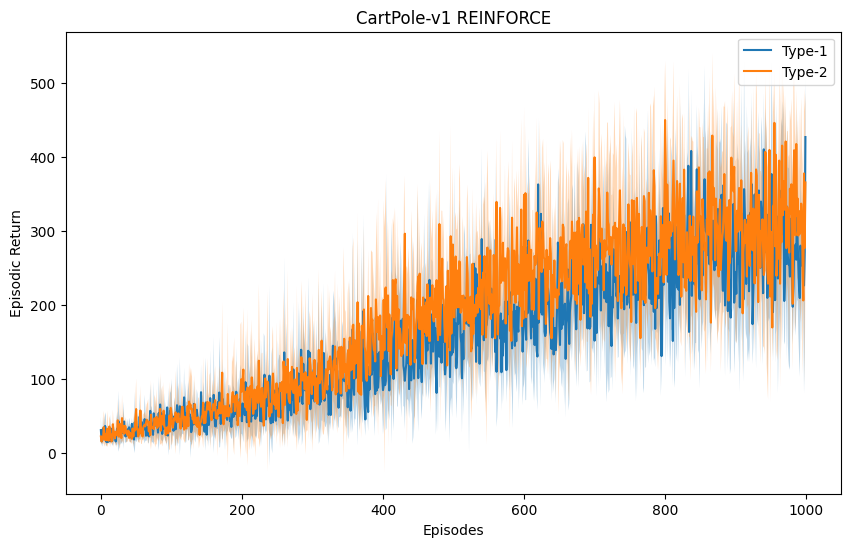

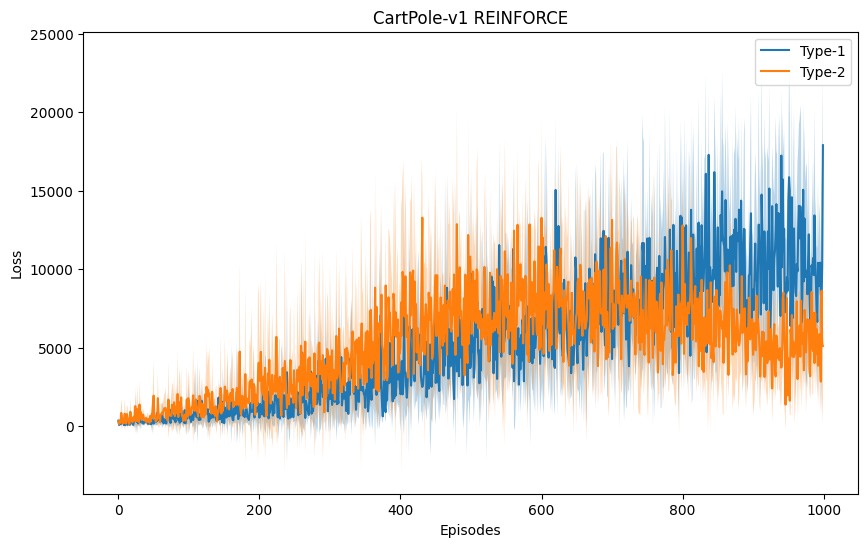

In [25]:
# Monte Carlo REINFORCE
# CartPole-v1 without baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False, args=args)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# CartPole-v1 with baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True, args=args)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Load results
rewards_mean1, rewards_std1, losses_mean1, losses_std1 = results_loader("CartPole-v1", "reinforce", baseline=False)
rewards_mean2, rewards_std2, losses_mean2, losses_std2 = results_loader("CartPole-v1", "reinforce", baseline=True)

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "CartPole-v1 REINFORCE", "plots/reinforce_cartpole_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "CartPole-v1 REINFORCE", "plots/reinforce_cartpole_losses")
